In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

bike_df = pd.read_csv('../datasets/bike_train.csv')

print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [2]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [3]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [4]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
 15  hour        10886 non-null  int64         
dtypes: datetime64[ns](1), 

In [5]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis = 1, inplace = True)

In [6]:
# 에러 함수들 정의 후 선형회귀 학습 / 예측

from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error()를 이용하여 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MAE, RMSE, RMSLE 를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    # MAE는 scikit learn의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE : {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val, rmse_val, mae_val))

In [7]:
# 학습 데이터, 테스트 데이터 분리
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0)

# 선형회귀 적용 후 학습/예측/평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE : 1.165, RMSE: 140.900, MAE: 105.924


- RMSLE에 비해 RMSE이 매우 크게 나왔다. 예측 에러가 매우 큰 값들이 섞여 있기 때문

In [9]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns = ['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff', ascending = False)[:n_tops])

get_top_error_data(y_test, pred, n_tops = 5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


In [11]:
# 타겟 컬럼인 count 값을 log1p로 Log 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size = 0.3, random_state = 0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 Log 변한된 타겟 기반으로 학습되어 예측되었으므로 다시 expm1으로 scale 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE : 1.017, RMSE: 162.594, MAE: 109.286


<AxesSubplot:>

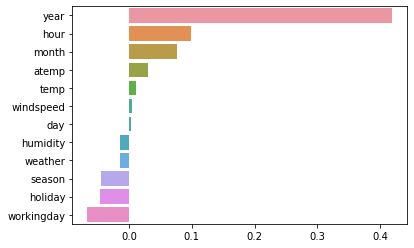

In [12]:
# 피처별 회귀 계수 확인
coef = pd.Series(lr_reg.coef_, index = X_features.columns)
coef_sort = coef.sort_values(ascending = False)
sns.barplot(x = coef_sort.values, y = coef_sort.index)

In [13]:
# 'year', 'month', 'hour', 'season', 'weather' feature 들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns = ['year', 'month', 'hour', 'holiday', 'workingday', 'season', 'weather'])

In [14]:
# 원-핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size = 0.3, random_state = 0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred)
    # end of function get_model_predict

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha = 10)
lasso_reg = Lasso(alpha = 0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = True)

### LinearRegression ###
RMSLE : 0.589, RMSE: 97.488, MAE: 63.108
### Ridge ###
RMSLE : 0.589, RMSE: 98.407, MAE: 63.648
### Lasso ###
RMSLE : 0.634, RMSE: 113.031, MAE: 72.658


<AxesSubplot:>

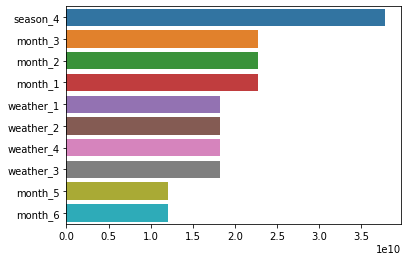

In [15]:
coef = pd.Series(lr_reg.coef_, index = X_features_ohe.columns)
coef_sort = coef.sort_values(ascending = False)[:10]
sns.barplot(x = coef_sort.values, y = coef_sort.index)

### 회귀 트리 사용

In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators = 500)
gbm_reg = GradientBoostingRegressor(n_estimators = 500)

for model in [rf_reg, gbm_reg]:
    # XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능. ndarray로 변환
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1 = True)

### RandomForestRegressor ###
RMSLE : 0.353, RMSE: 50.713, MAE: 31.433
### GradientBoostingRegressor ###
RMSLE : 0.340, RMSE: 55.761, MAE: 34.331
